# Assignment (other assignment is [here](https://github.com/philbowman212/Thinkful_repo/blob/master/assignments/3_supervised_learning/regression_problems/regression_assumptions_temp.ipynb))
### 1.2. House prices

To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

* Load the **houseprices** data from Thinkful's database. 
* Reimplement the model you built in the previous checkpoint. 
* Check for all of the assumptions above and discuss the implications if some of the assumptions are not met.
*  be sure to close the database connection after initially pulling in your data.

# Imports/Instantiation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
%matplotlib inline

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

# Cleaning

In [3]:
df.drop(columns='id', inplace=True)

In [4]:
cat_list = ['mssubclass','mszoning','street','alley','lotshape','landcontour','utilities','lotconfig','landslope','neighborhood','condition1','condition2',
            'bldgtype','housestyle','roofstyle','roofmatl','exterior1st','exterior2nd','masvnrtype','exterqual','extercond','foundation','bsmtqual','bsmtcond',
            'bsmtexposure','bsmtfintype1','bsmtfintype2','heating','heatingqc','centralair','electrical','kitchenqual','functional','fireplacequ','garagetype',
            'garagefinish','garagequal','garagecond','paveddrive','poolqc','fence','miscfeature','saletype','salecondition', 'overallqual', 'overallcond', 
            'yearbuilt', 'yearremodadd', 'mosold', 'yrsold']
for var in cat_list:
    df[var] = df[var].astype('category')

In [5]:
def add_cat_fillna(variable, new_cat='None'):
    df[variable] = df[variable].cat.add_categories(new_cat).fillna(new_cat).copy()

In [6]:
nulls_list = ['alley','bsmtqual','bsmtcond','bsmtexposure','bsmtfintype1','bsmtfintype2','fireplacequ','garagetype','garagefinish','garagequal','garagecond',
             'poolqc','fence','miscfeature']
for var in nulls_list:
    add_cat_fillna(var)

In [7]:
df.masvnrtype = df.masvnrtype.fillna('None').copy()
df.masvnrarea = df.masvnrarea.fillna(0).copy()
df.lotfrontage = df.lotfrontage.fillna(df.lotfrontage.median()).copy()
df.electrical = df.electrical.fillna(df.electrical.mode()[0]).copy()
df.drop(columns='garageyrblt', inplace=True)

In [8]:
def outliers_std(data, columns, thresh=2):
    outlier_indexes = []
    for col in columns:
        ser_col = data[col]
        mean = ser_col.mean()
        sd = ser_col.std()
        outliers_mask = data[(data[col] > mean + thresh*sd) | (data[col] < mean - thresh*sd)].index
        outlier_indexes += [x for x in outliers_mask]
    return list(set(outlier_indexes))

In [9]:
df.drop(outliers_std(df, df.describe().columns), inplace=True)

Cleaning done!

# Feature Engineering

In [10]:
data = pd.DataFrame()
data['totalsf'] = df.totalbsmtsf + df.firstflrsf + df.secondflrsf
data['grlivarea'] = df.grlivarea
data['bedroomabvgr'] = df.bedroomabvgr
data['totalbath'] = df.fullbath + df.halfbath
data['garagearea'] = df.garagearea
data['selling_age'] = df.yrsold.astype('int') - df.yearbuilt.astype('int')
data['target'] = df.saleprice

# Modeling

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

target = scaled_data.iloc[:, -1]
X_data = scaled_data.iloc[:, :-1]

X_train, X_test, Y_train, Y_test = train_test_split(X_data, target, test_size=.3, random_state=14)

lm = LinearRegression()
lm.fit(X_train, Y_train)
Y_pred = lm.predict(X_test)

### Evaluation

Mean squared error: 0.14714590815599848
Mean absolute error: 0.3030245519470906
R^2: 0.8403104720074868


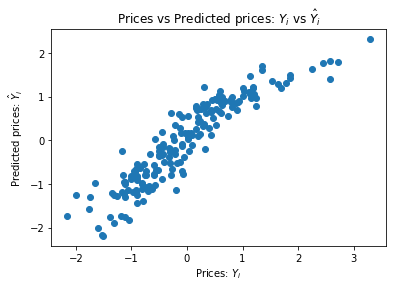

In [12]:
from sklearn import metrics
def evaluate(Y_test, Y_pred):
    mse = metrics.mean_squared_error(Y_test, Y_pred)
    msa = metrics.mean_absolute_error(Y_test, Y_pred)
    r2 = metrics.r2_score(Y_test, Y_pred)
    
    print('Mean squared error:', mse)
    print('Mean absolute error:', msa)
    print('R^2:', r2)
    
    plt.scatter(Y_test, Y_pred)
    plt.xlabel('Prices: $Y_i$')
    plt.ylabel('Predicted prices: $\hat{Y}_i$')
    plt.title('Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$')
evaluate(Y_test, Y_pred)

### The Assumptions
1. Linearity of models in their coefficients
2. Error term should be zero on average
3. Homoscedasticity
4. Low Multicollinearity
5. Error terms should be uncorrelated with each other
6. Features shouldn’t be correlated with the errors

    (sorta 7.) Normality of the errors

#### 1. Linearity of models in their coefficients
The only requirement of this model is that our coefficients end up being a linear relationship of our features. Using a linear model, assumes this already in code we can see that our coefficients remain constant (linear) regardless of changes to other variables.

In [13]:
lm.coef_

array([ 0.41932361,  0.20991849, -0.08431693,  0.07163659,  0.13248309,
       -0.33094162])

#### 2. Error term should be zero on average

This pretty much means exactly what it says and we can test this assumption rather easily.

In [14]:
errors = Y_test - Y_pred
np.mean(errors)

-0.013902914840022344

This isn't quite zero, but it is incredibly close, if we don't include a constant in our model, then this could become an issue, but Sci-Kit Learn does the heavy lifting and already assumes that there is a constant (y-intercept). This assumption is usually a non-issue, just don't forget about the constant.

#### 3. Homoscedasticity

We have homoscedasticity when the distribution of the error terms is consistent for all predicted values. Let's do a visual test...

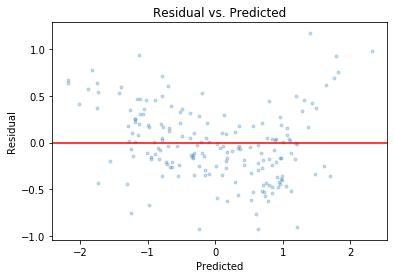

In [15]:
plt.scatter(Y_pred, errors, alpha=.25, marker='.')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0, color='red')
plt.title('Residual vs. Predicted')
plt.show()

This distribution doesn't look too bad, looks like up higher there is more variance, but it isn't conclusive. Let's dig into some statistical testing! Time to look for some help from our friends Bartlett and Levene...

In [16]:
from scipy.stats import bartlett, levene

bartlett(Y_pred, errors), levene(Y_pred, errors)

(BartlettResult(statistic=138.35345988784394, pvalue=6.099422728733188e-32),
 LeveneResult(statistic=173.59309448650342, pvalue=9.007501146938692e-33))

The tests are highly significant! This means that our errors are heteroscedastic rather than homoscedastic. This is less than optimal and leads to overconfidence in the accuracy of the model's predictions. There are a number of possible causes. The main ones are the presence of outliers (which I think we took care of) and leaving out variables that are important in explaining the variance of the target variable. Note, the estimated coefficients are still valid, but not necessarily statistically significant.

Things that could possibly be done here:
- Add variable that describes dependent variables variance more robustly
- Transform the dependent variable using boxcox or log transformation
- Eliminate outliers (should be done already)

#### 4. Low Multicollinearity

The features themselves optimally would be completely uncorrelated, and at most weakly correlated. If two variables (or more) are highly correlated with one another, then they may explain mostly the same variance for a dependent variable. This takes away our ability to know the relative power of each variable since each variable could be a linear combination of others. Let's get a visual...

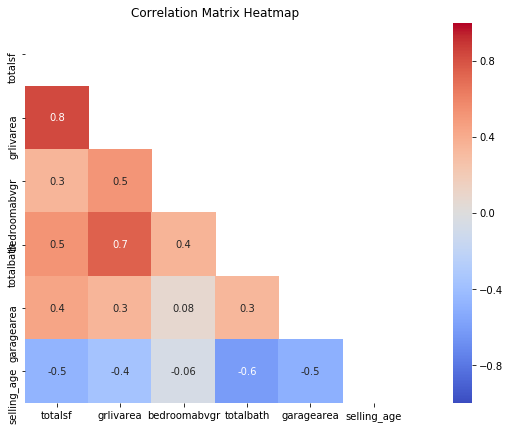

In [17]:
mask = np.triu(scaled_data.iloc[:, :-1].corr())
plt.figure(figsize=(17,7))
sns.heatmap(scaled_data.iloc[:, :-1].corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask, square=True)
plt.ylim(scaled_data.iloc[:, :-1].corr().shape[1], 0)
plt.title('Correlation Matrix Heatmap')
plt.show()

It appears that the mass majority of the data here has a pretty decent correlation with one another, indicating multicollinearity, that means we won't be able to recognize the relative power between variables since many are a linear combination of some sort of the others.

A few possible courses of action:
- PCA (dimensionality reduction)
- Remove some of the correlated features

#### 5. Error terms should be uncorrelated with each other

The error terms should not be able to predict the error terms for other values. Quick visual...

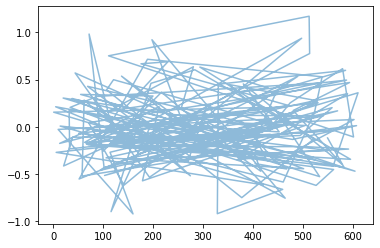

In [18]:
plt.plot(errors, alpha=.5)
plt.show()

Looks like a jumbled mess, which is good, because it implies there is no correlation. There is a more direct and explicit way to deal with this using the autocorrelation function or ACF.

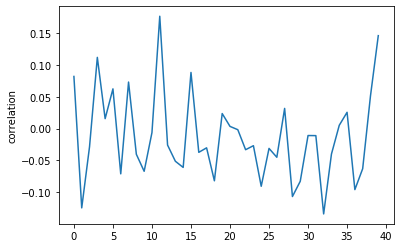

In [19]:
from statsmodels.tsa.stattools import acf
plt.plot(acf(errors, fft=False)[1:])
plt.ylabel('correlation')
plt.show()

The correlation between error values at its highest is less than .2 and at its lowest -.12. This shows that there may be a slight correlation between the errors, which is not good, we are likely missing a relevant variable for this model.

#### 6. Features shouldn’t be correlated with the errors

Also known as the exogeneity assumption, this assumes features and errors are independent of one another. This will usually occur if you either omit a relevant variable from the model or if there is simultaneity in the effect between an independent and dependent variable.

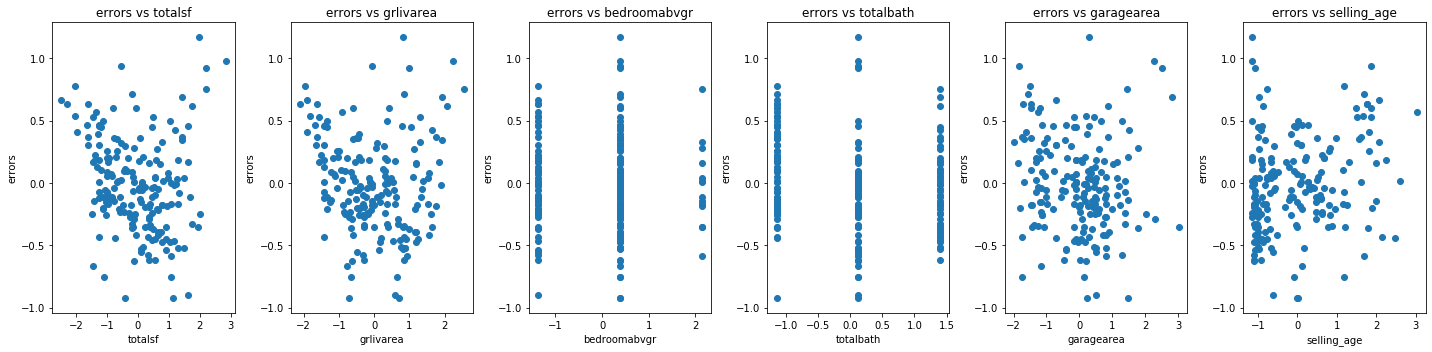

In [20]:
plt.figure(figsize=(20, 5))
for i, col in enumerate(X_test.columns, 1):
    plt.subplot(1, 6, i)
    plt.scatter(X_test[col], errors)
    plt.xlabel(col)
    plt.ylabel('errors')
    plt.title('errors vs {}'.format(col))
plt.tight_layout()
plt.show()

It would appear, based on the above, we don't have a relationship between errors... This is good. It means we don't have exogeneity.

#### 7(ish). Normality of the errors

Not an assumption, but does carry weight when it comes to the results. We don't need it to come up with coefficients. But we do need it if we want to measure the statistical significance of our coefficients (t-tests and F-tests, yay!). If the errors aren't normal, then the significance tests are useless. Visually...

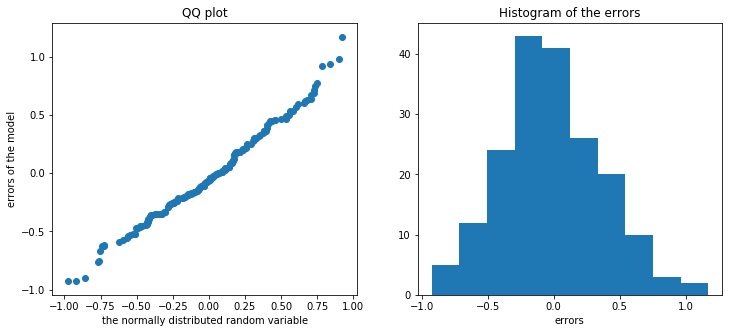

In [21]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors))
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")
plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")
plt.show()

So, based on the above, the errors appear to be normal...

A more direct and formal statistical method could be performed as well thanks to our friends Jarque Bera and Normal test.

In [22]:
from scipy.stats import jarque_bera, normaltest
jarque_bera(errors), normaltest(errors)

((3.0346339623611587, 0.21929948297404245),
 NormaltestResult(statistic=3.3258288374119913, pvalue=0.18958564222197055))

These highly significant results indicate that our data deviates more drastically from the norm than it may have appeared...this will likely make it difficult to garner any significance from our coefficients...bummer.